In [27]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pylab

In [2]:


# Check GPUs available
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {gpus}")

# Check if TensorFlow is currently executing eagerly (which means operations are executed as they are defined and is the default mode in TF 2.x)
print(f"Eager execution: {tf.executing_eagerly()}")

# If you have GPUs listed and eager execution is enabled, then operations should automatically run on the GPU if possible.
# To test if TensorFlow will place tensors and operations on the GPU by default, you can create a simple operation and see where it is placed:
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        print(a.device)
else:
    print("No GPU found!")

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution: True
/job:localhost/replica:0/task:0/device:GPU:0


2024-02-10 16:49:48.413055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 16:49:48.442269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 16:49:48.442531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Retrieve data and preprocessing

In [2]:
# This is the list that will hold all of the data (data22 and MC)

datasets = []
pass_HLT = []
tags = ['data', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jjJZ4', 'jjJZ2', 'qqa']

In [3]:
# Read EB data22 file

with h5py.File('../../../../ntuples/AOD_EB_ntuples_02-10-2024.h5', 'r') as hf:
    jets = hf['HLT_jets'][:]
    electrons = hf['electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    muons = hf['muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    photons = hf['photons'][:]
    MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

In [4]:
print(jets.shape)

(1019220, 10, 4)


In [5]:
# Collect only events that passed any of our unprescaled L1 list, and concatenate. Remove E.

pass_L1_idxs = (pass_L1_unprescaled == 1) # Indices of events that passed L1
pass_HLT_unprescaled = pass_HLT_unprescaled[pass_L1_idxs]
data = np.concatenate([jets[pass_L1_idxs], electrons[pass_L1_idxs], muons[pass_L1_idxs], photons[pass_L1_idxs], MET[pass_L1_idxs]], axis=1)
weights = EB_weights[pass_L1_idxs]
datasets.append(data[:, :, [0, 2, 3]])
pass_HLT.append(pass_HLT_unprescaled)

In [6]:
# Read MC data. Remove E.

filenames = ['HHbbttHadHad.h5', 'ZZ4lep.h5', 'Ztautau.h5', 'jjJZ4.h5', 'jjJZ2.h5', 'qqa.h5']
data_path = '../../../../ntuples/MC_02-10-2024/'

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets.append(combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]])
        pass_HLT.append(pass_HLT_unprescaled)

In [7]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for i, data in enumerate(datasets):

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [8]:
"""Normalize pt """
for i, data in enumerate(datasets):
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= sum_pt

In [9]:
for i, dataset in enumerate(datasets):
    print(f'{tags[i]}: {dataset.shape}')

data: (224294, 20, 3)
HHbbttHadHad: (20000, 20, 3)
ZZ4lep: (100000, 20, 3)
Ztautau: (100000, 20, 3)
jjJZ4: (100000, 20, 3)
jjJZ2: (100000, 20, 3)
qqa: (50000, 20, 3)


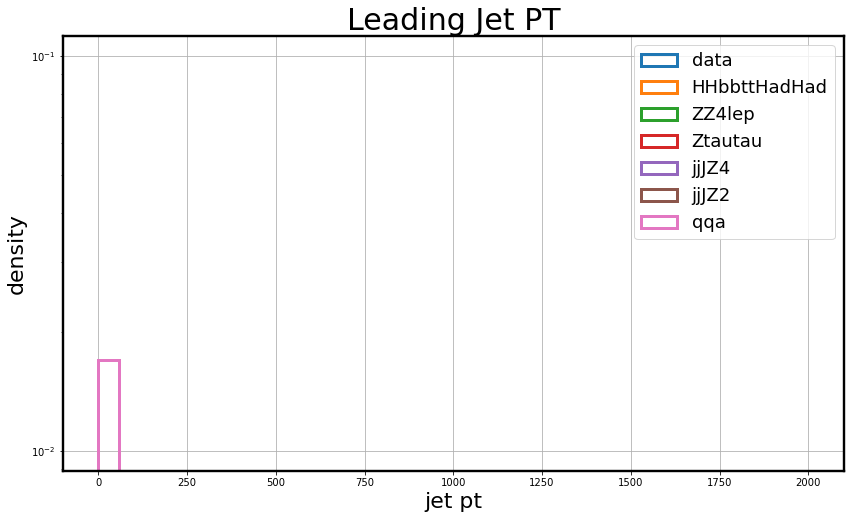

In [10]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 2000, 35)
#bins=50

for i, tag in enumerate(tags):
    pt = datasets[i][:, 0, 0]
    nonzero_pt = pt[pt > 0]

    if i==0:
        nonzero_weights = weights[pt > 0]
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=nonzero_weights)
    else:
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Leading Jet PT', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

# Define Classes

In [11]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)  
    
    def __getitem__(self, index):
        return [torch.from_numpy(self.X[index]), torch.from_numpy(self.y[index])]

    def collate_fn(self, batch):
        X = [torch.tensor(sample[0]).float() for sample in batch]
        y = [torch.tensor(sample[1]).float() for sample in batch]
        return torch.stack(X, 0), torch.stack(y, 0)

    def create_dataloader(self, batch_size, shuffle=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle)

In [12]:
class ShuffleUnshuffleLayer(nn.Module):
    def __init__(self):
        super(ShuffleUnshuffleLayer, self).__init__()

    def forward(self, x, reverse=False, indices=None):
        if not reverse:
            # Shuffle
            batch_size, num_objects, _ = x.size()
            indices = torch.randperm(num_objects).to(x.device)
            return x[:, indices], indices
        else:
            # Unshuffle
            if indices is None:
                raise ValueError("Indices for unshuffling not provided")
            unshuffled = torch.zeros_like(x)
            for i, idx in enumerate(indices):
                unshuffled[:, idx] = x[:, i]
            return unshuffled

In [15]:
class DNN_AE(nn.Module):
    def __init__(self, input_shape, h_dim_1, h_dim_2, latent_dim):
        super(DNN_AE, self).__init__()
        self.input_shape = input_shape
        input_dim = np.prod(input_shape)
        self.shuffle_layer = ShuffleUnshuffleLayer()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, h_dim_1)
        self.fc2 = nn.Linear(h_dim_1, h_dim_2)
        self.fc3 = nn.Linear(h_dim_2, latent_dim)

        # Decoder layers
        self.fc4 = nn.Linear(latent_dim, h_dim_2)
        self.fc5 = nn.Linear(h_dim_2, h_dim_1)
        self.fc6 = nn.Linear(h_dim_1, input_dim)

    def forward(self, x):
        # x shape: [batch_size, 20, 3]
        x, indices = self.shuffle_layer(x)  # Shuffle
        x = x.view(x.size(0), -1)  # Flatten

        # Encoder
        z = F.relu(self.fc1(x))
        z = F.relu(self.fc2(z))

        # Decoder
        z = F.relu(self.fc3(z))
        z = self.fc4(z)

        z = z.view(-1, *self.input_shape)  # Reshape back
        z = self.shuffle_layer(z, reverse=True, indices=indices)  # Unshuffle
        return z

    def loss_function(self, x, y):
        mask = (y != 0)
        return F.mse_loss(x[mask], y[mask])

In [14]:
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch.

        returns: average loss over most recent {num_batches_avg} batches, loss over most recent batch
        """

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets = batch
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true = batch
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, y_true)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []

        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)

        return np.vstack(model_outputs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'average train loss over most recent {self.num_batches_avg} batches: {avg_train_loss},'
            f'average val loss over most recent {self.num_batches_avg} batches: {avg_val_loss},'
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

# Initialize Objects

In [16]:
# Make train, test, val splits

TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2

X_train, X_, weights_train, weights_, pass_HLT_train, pass_HLT_ = train_test_split(datasets[0], weights, pass_HLT[0], train_size=TRAIN_SIZE)
X_val, X_test, weights_val, weights_test, pass_HLT_val, pass_HLT_test = train_test_split(X_, weights_, pass_HLT_, train_size=0.5)

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')

X_train: (134576, 20, 3)
X_val: (44859, 20, 3)
X_test: (44859, 20, 3)


In [17]:
# Initialize datasets
train_dataset = Dataset(X=X_train, y=X_train)
test_dataset = Dataset(X=X_test, y=X_test)
val_dataset = Dataset(X=X_val, y=X_val)

In [18]:
BATCH_SIZE = 1024

In [19]:
# Initialize dataloaders
train_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
val_loader = val_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
batch_X, batch_y = next(iter(train_loader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n")

Sample batch:
  X: [1024, 20, 3]
  y: [1024, 20, 3]



/tmp/ipykernel_8338/3456955486.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
/tmp/ipykernel_8338/3456955486.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [23]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE = 6
NUM_EPOCHS = 20
INPUT_SHAPE = X_train.shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3

In [24]:
dense_AE = DNN_AE(input_shape=INPUT_SHAPE, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
print(dense_AE.named_parameters)

<bound method Module.named_parameters of DNN_AE(
  (shuffle_layer): ShuffleUnshuffleLayer()
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=20, bias=True)
)>


In [25]:
# Initialize the loss function, optimizer and lr scheduler, trainer

def loss_fn(x, y):
    return dense_AE.loss_function(x, y)

optimizer = Adam(params=dense_AE.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, verbose=True)
trainer = Trainer(model=dense_AE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [28]:
# Train
best_model = trainer.train(
    num_epochs=NUM_EPOCHS, patience=PATIENCE,
    train_dataloader=train_loader, val_dataloader=val_loader)

/tmp/ipykernel_8338/3456955486.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
/tmp/ipykernel_8338/3456955486.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x60 and 20x32)

In [36]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [37]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [38]:
total_loss = []

for i, prediction in enumerate(predictions):
    total_loss.append(AD_score(y_true[i], prediction))

<Figure size 1296x720 with 0 Axes>

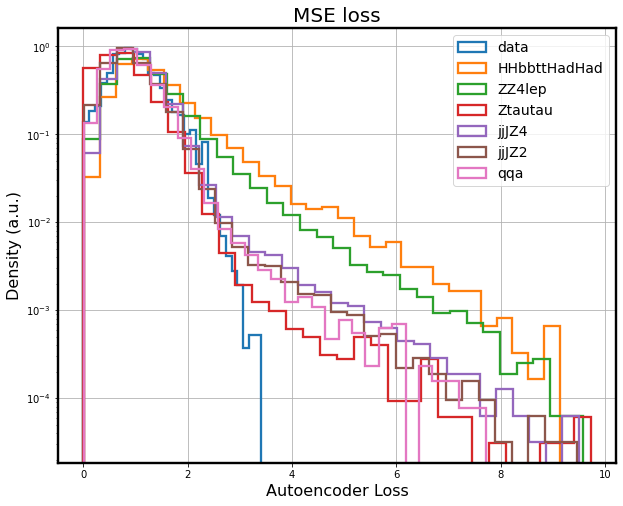

In [39]:
plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for i, tag in enumerate(tags):
    if i==0:
        plt.hist(total_loss[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights_test)
    else:
        plt.hist(total_loss[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3)


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

data: TPR at FPR of 10^-4 is 0.0001 with threshold 3.2699


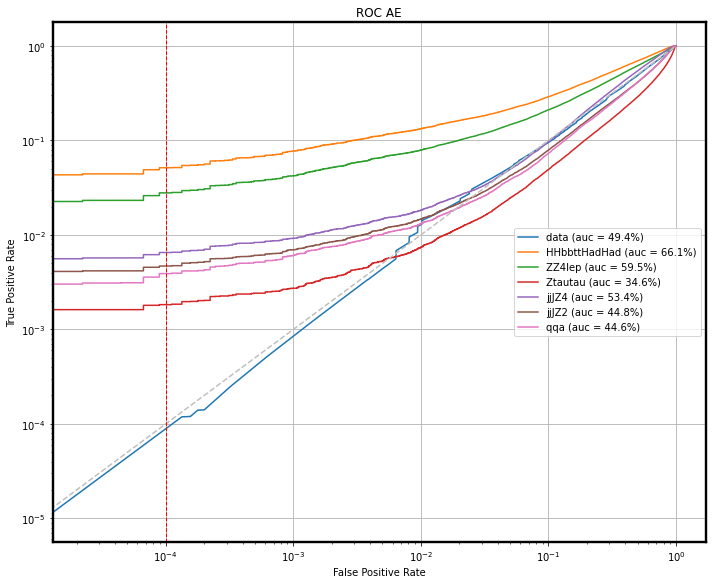

In [49]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))

for i, label in enumerate(tags):
    # Combine true labels, anomaly=1 and background=0
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background))
    
    # Combine predictions from current dataset and background
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
    
    # Include weights for the EB data and assign no weight (or equal weight) for the other dataset
    if i == 0:  # For the EB data
        sample_weights = np.concatenate((weights_test, np.ones_like(target_background)))
    else:  # For the MC datasets, assume equal weight
        sample_weights = np.concatenate((np.ones(total_loss[i].shape[0]), np.ones_like(target_background)))

    # Calculate ROC curve and AUC, including weights
    fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Plot ROC curve
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (label, auc_loss*100.), linewidth=1.5)

    # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
    if i ==0: 
        target_fpr = 10**-4
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.4f} with threshold {threshold_loss[idx]:.4f}")
        threshold = threshold_loss[idx]

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()

# Additional plot elements
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.0001, color='red', linestyle='dashed', linewidth=1)  # Threshold value
plt.title("ROC AE")
plt.show()

In [50]:
"""Print the HLT overlap (the percentage of events we found as anomalous that
are already being triggered by the HLT)"""

for i, tag in enumerate(tags):
    anomaly_idxs = (total_loss[i] > threshold)
    HLT_overlap = 0

    if i ==0:
        for a, h in zip(anomaly_idxs, pass_HLT_test):
            if a==1 and h==1:
                HLT_overlap += 1
        HLT_overlap /= np.sum(anomaly_idxs)
    else:
        for a, h in zip(anomaly_idxs, pass_HLT[i]):
            if a==1 and h==1:
                HLT_overlap += 1
        HLT_overlap /= np.sum(anomaly_idxs)

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_test) / len(pass_HLT_test)}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

-----
data:
HLT overlap: 0.0
percentage of events that passed some HLT trigger: 0.03294768051004258
percentage of events that we tagged as anomalous: 6.687621213134488e-05
number of events that we tagged as anomalous: 3
-----
HHbbttHadHad:
HLT overlap: 0.6340468909276249
percentage of events that passed some HLT trigger: 0.03294768051004258
percentage of events that we tagged as anomalous: 0.04905
number of events that we tagged as anomalous: 981
-----
ZZ4lep:
HLT overlap: 0.9275306748466258
percentage of events that passed some HLT trigger: 0.03294768051004258
percentage of events that we tagged as anomalous: 0.02608
number of events that we tagged as anomalous: 2608
-----
Ztautau:
HLT overlap: 0.18888888888888888
percentage of events that passed some HLT trigger: 0.03294768051004258
percentage of events that we tagged as anomalous: 0.0018
number of events that we tagged as anomalous: 180
-----
jjJZ4:
HLT overlap: 0.9789983844911146
percentage of events that passed some HLT trigger: 0

In [48]:
DNN_AE.save('../../trained_models/DNN_AE_norm_v1.keras')

***
<hr style="border:2px solid #F08080">

In [55]:
HLT_rate = np.sum(weights * pass_HLT[0]) / np.sum(weights)
print(f'HLT acceptance: {HLT_rate}')
print(f'HLT rejection: {1/HLT_rate}')

HLT acceptance: 0.01663002240942737
HLT rejection: 60.13221001031913
